## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 2_DeployEndpoint.ipynb notebook
%store -r ENDPOINT_NAME
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: yolov8-pytorch-2023-11-19-11-17-06-065822
Endpoint Status = InService


In [3]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.3 Run Inference and Generate output results

Inference Time = 0.9513 seconds


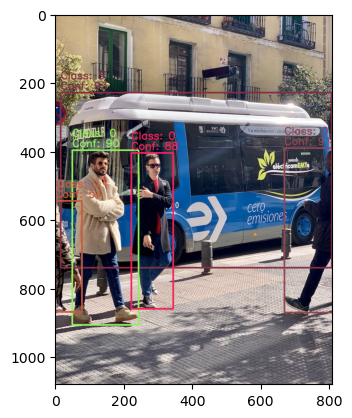

In [6]:
infer_start_time = time.time()

orig_image = cv2.imread('bus.jpg')

image_height, image_width, _ = orig_image.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height

resized_image = cv2.resize(orig_image, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

if 'boxes' in result:
    for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
        # Draw Bounding Boxes
        x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
        y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
        color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
        cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
        cv2.putText(orig_image, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        if 'masks' in result:
            # Draw Masks
            mask = cv2.resize(np.asarray(result['masks'][idx]), dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            for c in range(3):
                orig_image[:,:,c] = np.where(mask>0.5, orig_image[:,:,c]*(0.5)+0.5*color[c], orig_image[:,:,c])

if 'probs' in result:
    # Find Class
    lbl = result['probs'].index(max(result['probs']))
    color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    cv2.putText(orig_image, f"Class: {int(lbl)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    
if 'keypoints' in result:
    # Define the colors for the keypoints and lines
    keypoint_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    line_color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))

    # Define the keypoints and the lines to draw
    # keypoints = keypoints_array[:, :, :2]  # Ignore the visibility values
    lines = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Torso
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
    ]

    # Draw the keypoints and the lines on the image
    for keypoints_instance in result['keypoints']:
        # Draw the keypoints
        for keypoint in keypoints_instance:
            if keypoint[2] == 0:  # If the keypoint is not visible, skip it
                continue
            cv2.circle(orig_image, (int(x_ratio*keypoint[:2][0]),int(y_ratio*keypoint[:2][1])), radius=5, color=keypoint_color, thickness=-1)

        # Draw the lines
        for line in lines:
            start_keypoint = keypoints_instance[line[0]]
            end_keypoint = keypoints_instance[line[1]]
            if start_keypoint[2] == 0 or end_keypoint[2] == 0:  # If any of the keypoints is not visible, skip the line
                continue
            cv2.line(orig_image, (int(x_ratio*start_keypoint[:2][0]),int(y_ratio*start_keypoint[:2][1])),(int(x_ratio*end_keypoint[:2][0]),int(y_ratio*end_keypoint[:2][1])), color=line_color, thickness=2)

plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()

## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [5]:
# response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
# print(response)
# endpoint_config_name = response['EndpointConfigName']

# # Delete Endpoint
# sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# # Delete Endpoint Configuration
# sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# # Delete Model
# for prod_var in response['ProductionVariants']:
#     model_name = prod_var['ModelName']
#     sm_client.delete_model(ModelName=model_name)     